In [1]:
import inlaw.nb_util as util
util

<module 'inlaw.nb_util' from '/workspaces/confirmasaurus/inlaw/inlaw/nb_util.py'>

In [2]:
import inlaw.berry as berry
import inlaw.quad as quad
import inlaw.inla as inla
import jax
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
sig2_rule = quad.log_gauss_rule(100, 1e-6, 1e3)
sig2_rule.wts.sum()

999.9999989999563

In [43]:
rinla_df = pd.read_csv('hyperpar_data.csv')
rinla_sig2 = 1.0 / rinla_df['x'].to_numpy()
sig2_rule = quad.QuadRule(
    pts = rinla_sig2,
    wts = np.concatenate((rinla_sig2[:-1] - rinla_sig2[1:], [rinla_sig2[-1]]))
)

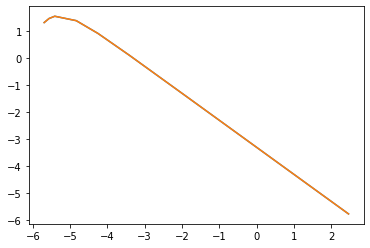

In [45]:
sig2 = sig2_rule.pts
sig2_alpha = 0.0005
sig2_beta = 0.000005
invg_pdf = scipy.stats.invgamma.pdf(sig2, sig2_alpha, scale=sig2_beta)
g_pdf = scipy.stats.gamma.pdf(sig2, sig2_alpha, scale=(1.0 / sig2_beta)*(sig2 ** 2))
plt.plot(np.log10(sig2), np.log10(invg_pdf))
plt.plot(np.log10(sig2), np.log10(g_pdf))
plt.show()

In [46]:
xs = np.linspace(0.3, 0.7, 10)
rr = 4.5
a = scipy.stats.invgamma.pdf(xs, 3, scale=rr)
b = scipy.stats.gamma.pdf(xs, 3, scale=(1.0 /rr) * xs ** 2)
a - b

array([ 4.33680869e-18,  5.20417043e-18,  3.46944695e-17,  0.00000000e+00,
        1.11022302e-16, -1.80411242e-16,  1.38777878e-16,  2.77555756e-17,
       -5.55111512e-17,  0.00000000e+00])

In [47]:
dtype = np.float64
data = berry.figure2_data(N=1)[0].astype(dtype)
inla_ops = berry.optimized(sig2, dtype=dtype).config(
    max_iter=10, opt_tol=dtype(1e-6)
)
logpost, x_max, _, iters = jax.jit(
    inla_ops.laplace_logpost
)(np.zeros((sig2.shape[0], 4), dtype=dtype), dict(sig2=sig2), data)

post = inla.exp_and_normalize(logpost, sig2_rule.wts.astype(dtype), axis=0)

In [58]:
rinla_post = (rinla_df['y'] / rinla_sig2 ** 2).to_numpy()

In [64]:
post[:10]

DeviceArray([2.32697063e-05, 4.51508876e-05, 1.04629181e-04,
             1.06121571e-03, 3.39556557e-03, 8.44626421e-03,
             2.13554534e-02, 3.69838566e-02, 5.47686738e-02,
             7.43822744e-02], dtype=float64)

In [72]:
sig2

array([2.93002583e+02, 2.17721163e+02, 1.48050031e+02, 4.81468852e+01,
       2.62831325e+01, 1.58887271e+01, 9.13005471e+00, 6.36918868e+00,
       4.81032016e+00, 3.78921851e+00, 3.05958021e+00, 2.50734380e+00,
       2.27755099e+00, 2.07159213e+00, 1.88560615e+00, 1.71643636e+00,
       1.65295456e+00, 1.59162557e+00, 1.56172012e+00, 1.53229941e+00,
       1.47492253e+00, 1.41938535e+00, 1.36554317e+00, 1.31326915e+00,
       1.28771391e+00, 1.26254105e+00, 1.21328212e+00, 1.16537914e+00,
       1.05116352e+00, 9.44032466e-01, 8.43137866e-01, 7.47718908e-01,
       5.70249959e-01, 4.06717929e-01, 2.52620522e-01, 1.08012189e-01,
       1.32609727e-02, 3.84591897e-04, 5.58516747e-05, 1.45623391e-05,
       3.85772412e-06, 2.71280880e-06, 2.01025906e-06])

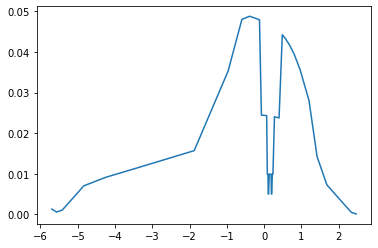

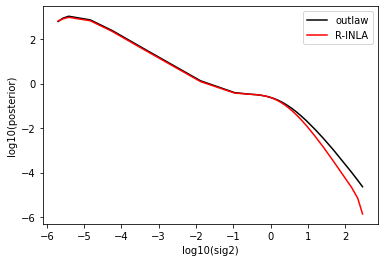

In [71]:
plt.plot(np.log10(sig2), rinla_post * sig2_rule.wts)
plt.show()
plt.plot(np.log10(sig2), np.log10(post), 'k-', label='outlaw')
plt.plot(np.log10(rinla_sig2), np.log10(rinla_post), 'r-', label='R-INLA')
plt.xlabel("log10(sig2)")
plt.ylabel("log10(posterior)")
plt.legend()
plt.show()

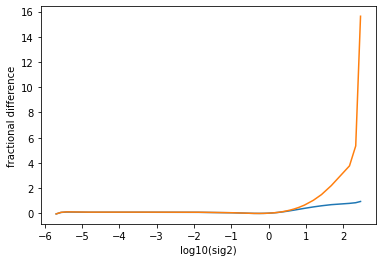

In [63]:
plt.plot(np.log10(sig2), (post - rinla_post) / post)
plt.plot(np.log10(sig2), (post - rinla_post) / rinla_post)
plt.xlabel("log10(sig2)")
plt.ylabel('fractional difference')
plt.show()

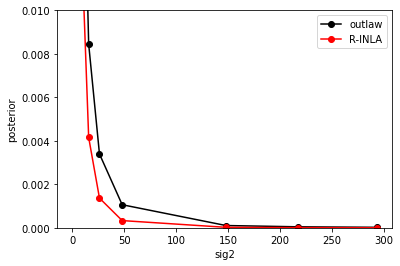

In [56]:
plt.plot(sig2, post, 'k-o', label='outlaw')
plt.plot(rinla_sig2, rinla_post, 'r-o', label='R-INLA')
plt.xlabel("sig2")
plt.ylabel("posterior")
plt.ylim([0, 0.01])
plt.legend()
plt.show()

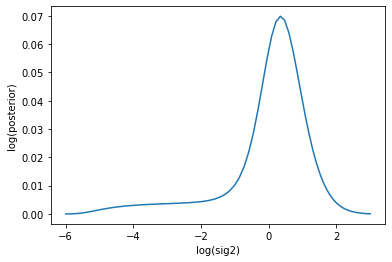

In [10]:
plt.plot(np.log10(sig2), post * sig2_rule.wts)
plt.xlabel("log(sig2)")
plt.ylabel("log(posterior)")
plt.show()